In [1]:
import numpy as np
import cv2


def process_image(original):
    processed = preprocess_image(original)
    corners = find_corners_of_largest_polygon(processed)

    underlying = preprocess_underlying_image(original)

    if not corners:
        return underlying

    with_lines = draw_lines(processed, corners)
    draw_points(with_lines, corners)
    
    return crop_and_warp(underlying, corners)


def preprocess_image(img):
    """Uses a blurring function, Otsu's thresholding and dilation 
    to expose the main features of an image."""

    # Gaussian blur with a kernel size (height, width) of 9.
    # Note that kernel sizes must be positive and odd and the kernel must be square.
    # 0 means that standard deviations both in X and Y directions are calculated from the kernel size.
    show(img, "before_blur")
    proc = cv2.GaussianBlur(img, (9, 9), 0)
    show(proc, "after_blur")

    # Otsu's threshold with maximum value of 255 (white),
    # The threshold value is determined automatically, 
    # therefore given threshold parameter 0 is ignored.
    # THRESH_BINARY means either 0 (black) or 255 (white).
    
    _, binary = cv2.threshold(proc, 127, 255, cv2.THRESH_BINARY)
    show(binary, "binary_threshold")
    
    val, proc = cv2.threshold(proc, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    print("Otsu's threshold is", val)
    show(proc, "otsu_threshold")

    # Invert colors, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise it would look like erosion instead.
    # ! bitwise_not modifies image in place
    proc = cv2.bitwise_not(proc, proc)

    # Dilate the image to increase the size of the grid lines.
    # A pixel will be considered white if at least one pixel in the original
    # image under the kernel is white.
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
    proc = cv2.dilate(proc, kernel)
    
    # Invert image back. Necessary for contours detection which happens next.
    proc = cv2.bitwise_not(proc, proc)
    
    show(proc, "after_dilation")

    return proc


def preprocess_underlying_image(img):
    """Uses a blurring function and adaptive thresholding."""
    proc = cv2.GaussianBlur(img, (9, 9), 0)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                 cv2.THRESH_BINARY, 11, 2)
    show(proc, "adaptive_thresholding")

    return proc


def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""

    # Find contours.
    # RETR_EXTERNAL returns only the extreme outer contours.
    # CHAIN_APPROX_SIMPLE compresses horizontal, vertical,
    # and diagonal segments and leaves only their end points.
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort by contour area, descending.
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    # Largest polygon
    polygon = contours[0]

    draw_contours(img, polygon)
    
    # If the found rectangle is smaller than 30% of the image,
    # it is probably wrong and the image won't be cropped.
    if cv2.contourArea(polygon) < 0.3 * img.shape[0] * img.shape[1]:
        return False

    # Bottom-right point has the largest (x + y) value.
    # Top-left has point smallest (x + y) value.
    # Bottom-left point has smallest (x - y) value.
    # Top-right point has largest (x - y) value.
    bottom_right = np.array([pt[0][0] + pt[0][1] for pt in polygon]).argmax()
    top_left = np.array([pt[0][0] + pt[0][1] for pt in polygon]).argmin()
    bottom_left = np.array([pt[0][0] - pt[0][1] for pt in polygon]).argmin()
    top_right = np.array([pt[0][0] - pt[0][1] for pt in polygon]).argmax()

    # Return an array of all 4 points using the indices.
    # Each point is in its own array of one coordinate.
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]


def distance_between(p1, p2):
    """Returns the scalar distance between two points."""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return ((a ** 2) + (b ** 2)) ** (1 / 2)


def crop_and_warp(img, crop_rect):
    """Crops and warps a quadrilateral section from an image into a rectangle of a similar size."""

    # Quadrilateral described by top left, top right, bottom right and bottom left points.
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 otherwise `getPerspectiveTransform`
    # would throw an error.
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    width = max([
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    height = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
    ])

    # Describe a rectangle with calculated width and height,
    # this is the new perspective we want to warp to.
    # Explicitly set the data type to float32 otherwise `getPerspectiveTransform`
    # would throw an error.
    dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a rectangle
    # by comparing the 4 source and destination points.
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the given image using transofrmation matrix m.
    return cv2.warpPerspective(img, m, (int(width), int(height)))


In [2]:
from matplotlib import pyplot as plt


def show(image, title="image"):
    plt.figure(figsize = (10, 10))
    plt.title(title)
    plt.imshow(image, "gray")
    plt.show()
    cv2.imwrite(f"output/{title}.jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    
def process_and_show_images(images):
    for image_name in images:
        img = cv2.imread(f"images/{image_name}", cv2.IMREAD_GRAYSCALE)
        img = process_image(img)
        show(img)

In [3]:
# utility functions for debugging

def to_color(img):
    """Dynamically change to a color image if necessary."""
    if len(img.shape) == 2:
        return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img        
        
            
def draw_points(img, points, radius=30, color=(255, 0, 0)):
    """Draw points on image."""
    
    colored_img = to_color(img)
    for point in points:
        colored_img = cv2.circle(colored_img, tuple(int(x) for x in point),
                                 radius, color, -1)
    show(colored_img, "with points")
    return colored_img

    
def draw_lines(img, points, thickness=15, color=(0, 255, 0)):
    """Draw lines on image."""
    
    colored_img = to_color(img)
    points = np.array(points, np.int32)
    points = points.reshape((-1,1,2))
    with_lines = cv2.polylines(colored_img, [points], 
                               True, color, thickness=thickness)
    show(with_lines, "with lines")
    return with_lines
    
def draw_bounding_box(img, contour, color=(255, 0, 0)):
    """Draw bounding box around contour."""
    
    colored_img = to_color(img)
    x,y,w,h = cv2.boundingRect(contour)
    with_box = cv2.rectangle(colored_img, (x, y), (x + w, y + h), color, 10)
    show(with_box, "with bounding box")
    return with_box

    
def draw_contours(img, contours, i=-1, color=(255, 0, 0)):
    """i is index of contour in `contours`. If `i = -1` all contours are drawn."""
    
    colored_img = to_color(img)
    with_contours = cv2.drawContours(colored_img, contours, i, color, 10)
    show(with_contours, "with contours")
    return with_contours

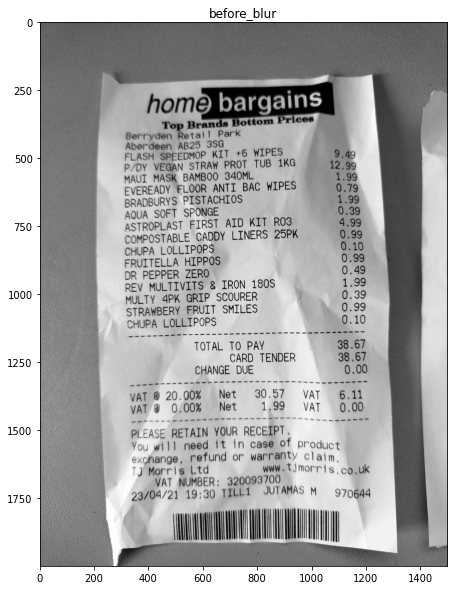

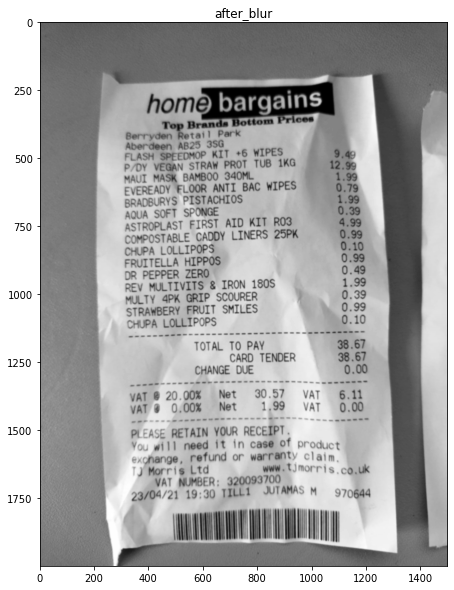

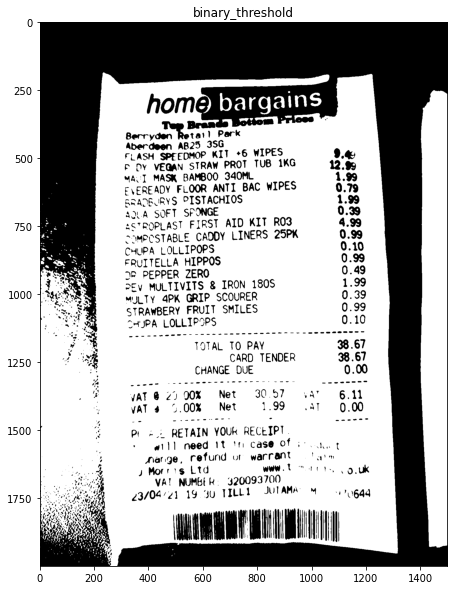

Otsu's threshold is 151.0


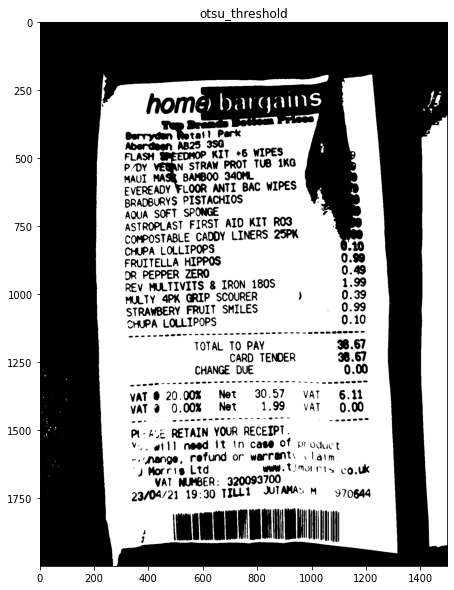

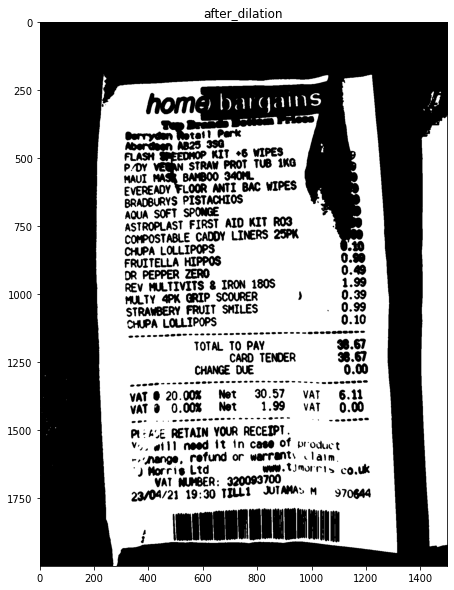

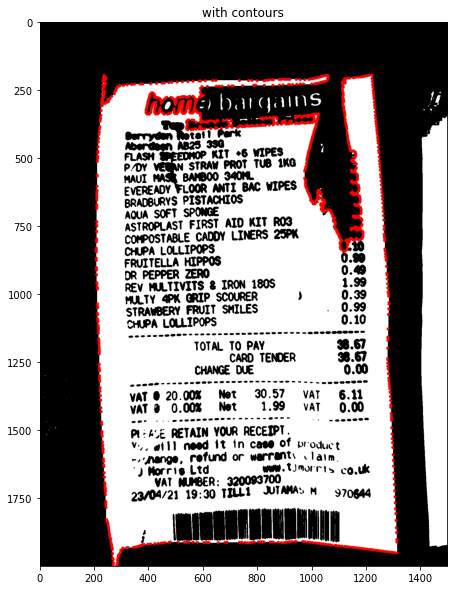

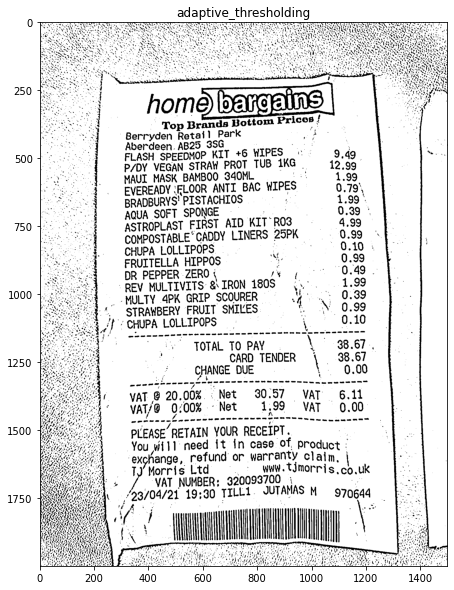

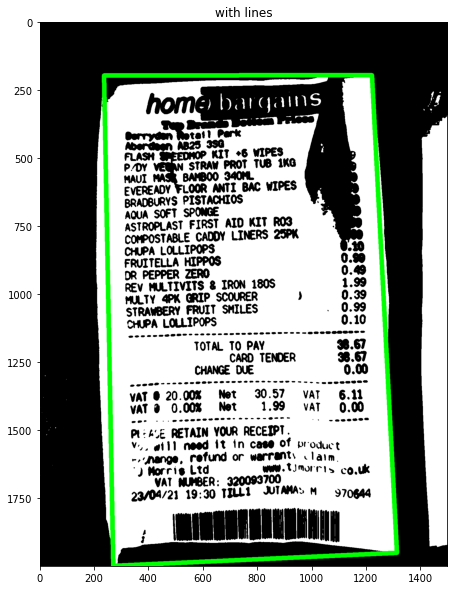

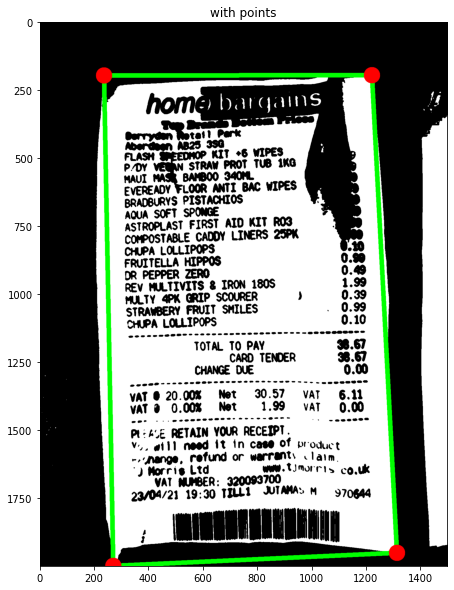

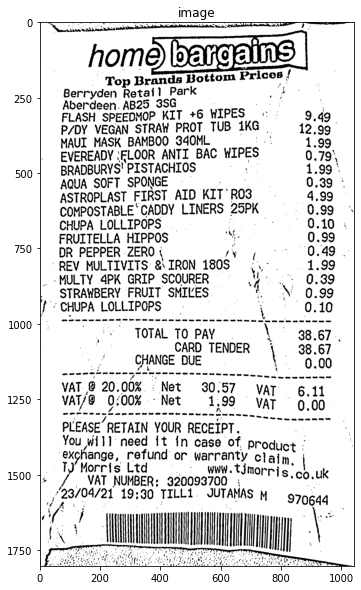

In [4]:
process_and_show_images(["home_bargains.jpg"])

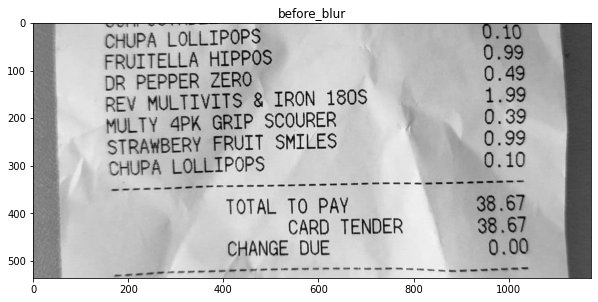

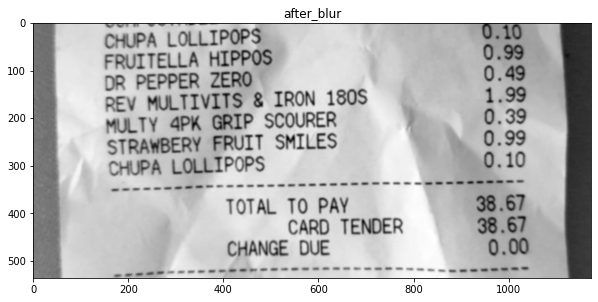

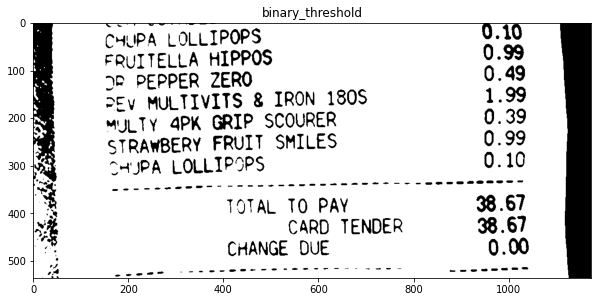

Otsu's threshold is 151.0


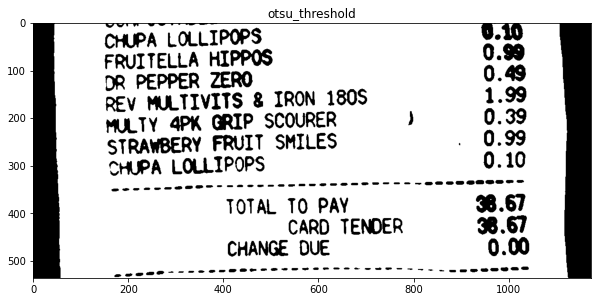

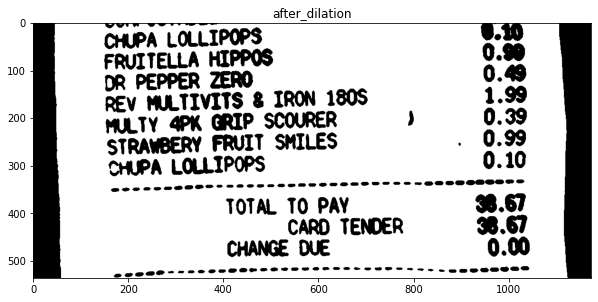

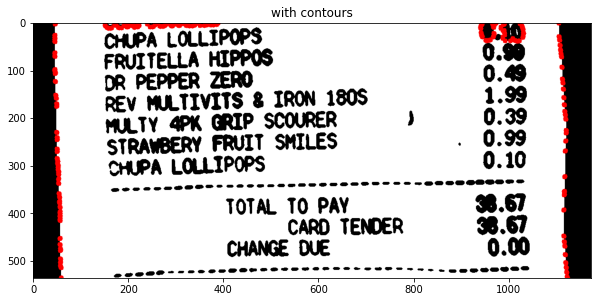

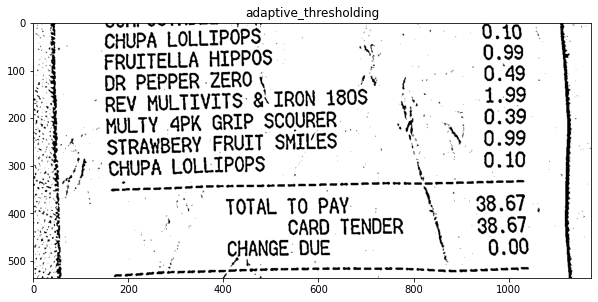

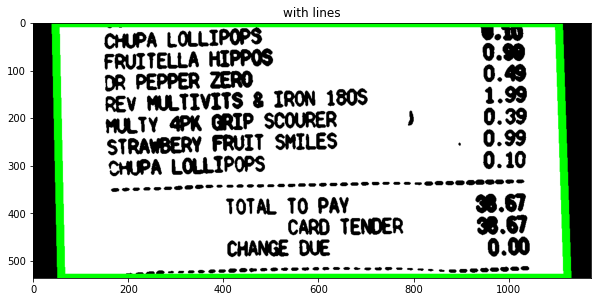

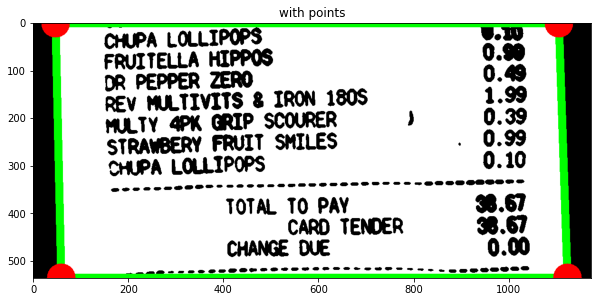

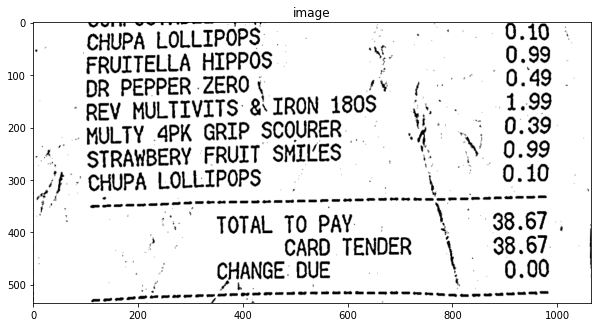

In [5]:
process_and_show_images(["home_bargains_cropped.jpg"])